In [1]:
!pip install contractions pydot textblob wordcloud rouge rouge-score

In [2]:
from textblob import Word
import nltk
nltk.data.path.append("/content/")
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Importing Required Libraries

In [3]:
# Libraray for Data Manipulation
import numpy as np
import pandas as pd

# Libraray for Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white",font_scale=1.5)
sns.set(rc={"axes.facecolor":"#FFFAF0","figure.facecolor":"#FFFAF0"})
sns.set_context("poster",font_scale = .7)

# Library for preprocessing
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import math
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
import re,string,unicodedata
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from scipy.sparse import lil_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import pos_tag

# Library for model building
from tensorflow.keras.regularizers import l2
import tensorflow
import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import SimpleRNN,LSTM,GRU, Embedding, Dense, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, Attention, Input, Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_datasets as tfds

#Library to overcome Warnings
import warnings
warnings.filterwarnings('ignore')

#Load and Inspect Dataset

In [4]:
train_df = pd.read_csv('/content/samsum-train.csv', encoding='latin-1')
test_df = pd.read_csv('/content/samsum-test.csv', encoding='latin-1')

In [5]:
train_df.sample(5)

,id,dialogue,summary
3757,13821237,Helen: how about this one?\nHelen: <file_other...,Helen's found an all-inclusive holiday offer t...
12125,13821776,Rico: say hello to our new family member\nRico...,Rico's looking for a name for her.
5075,13717320,Brian: How's the renovation going?\nGillian: o...,Renovation works at Gillian's and Brad's new a...
4721,13730020,Peter: are shops open this sunday??\nLance: i ...,"Peter doesn't know when the shops are open, an..."
6710,13865010,"Harriett: Tony, could you change the reservati...","Harriett, Tony, Nina and Tina are meeting this..."


In [6]:
test_df.sample(5)

,id,dialogue,summary
115,13829756,"Lisa: I have to clean the house.\r\nBob: Yes, ...","Bob is going to help Lisa clean the house, he ..."
786,13731481,Iris: <file_other>\r\nIris: My husband is famo...,Pete has got an interview. His wife Iris is ha...
436,13680387,Joanna: I need to get the coffie stains out of...,Joanna got her dress stained. Ethel recommends...
176,13727631,Andy: Hi nephew!\r\nPaul: Hi uncle!\r\nAndy: A...,Andy is going to visit Paul in about 1 hour.
187,13729824,Wendy: I think the upstairs toilet might be bl...,The toilet upstairs is blocked again. Wendy an...


#Data Exploration

In [7]:
print("train_df shape: ",train_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (14732, 3)
test_df shape:  (819, 3)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


In [9]:
print("Duplicates in Dataset: ",train_df.duplicated().sum())

Duplicates in Dataset:  0


#Preprocessing

## Dropping unwanted column

In [10]:
col = 'id'
train_df.drop(col,axis = 1,inplace = True)
test_df.drop(col,axis = 1,inplace = True)

##Dropping Duplicates and Null Values

In [11]:
train_df.dropna(inplace = True)

##Lowercasing

In [12]:
train_df['dialogue'] = train_df['dialogue'].str.lower()
train_df['summary'] = train_df['summary'].str.lower()
test_df['dialogue'] = test_df['dialogue'].str.lower()
test_df['summary'] = test_df['summary'].str.lower()

## Removing Html tags

In [13]:
import re
def remove_html_tags(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

In [14]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_html_tags)
train_df['summary'] = train_df['summary'].apply(remove_html_tags)
test_df['dialogue'] = test_df['dialogue'].apply(remove_html_tags)
test_df['summary'] = test_df['summary'].apply(remove_html_tags)

##Removing URLs

In [15]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

train_df['dialogue'] = train_df['dialogue'].apply(remove_url)
train_df['summary'] = train_df['summary'].apply(remove_url)
test_df['dialogue'] = test_df['dialogue'].apply(remove_url)
test_df['summary'] = test_df['summary'].apply(remove_url)

##Chat word treatment

In [16]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "IDC": "I don’t care",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing",
}

In [17]:
def chat_conversion(text):
    new_text=[]
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [18]:
train_df['dialogue'] = train_df['dialogue'].apply(chat_conversion)
train_df['summary'] = train_df['summary'].apply(chat_conversion)
test_df['dialogue'] = test_df['dialogue'].apply(chat_conversion)
test_df['summary'] = test_df['summary'].apply(chat_conversion)

## Removing Emojis

In [19]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [20]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_emoji)
train_df['summary'] = train_df['summary'].apply(remove_emoji)
test_df['dialogue'] = test_df['dialogue'].apply(remove_emoji)
test_df['summary'] = test_df['summary'].apply(remove_emoji)

##Removing contraction

In [21]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

train_df['dialogue'] = train_df['dialogue'].apply(expand_contractions)
train_df['summary'] = train_df['summary'].apply(expand_contractions)
test_df['dialogue'] = test_df['dialogue'].apply(expand_contractions)
test_df['summary'] = test_df['summary'].apply(expand_contractions)

In [22]:
train_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in train_df['summary']]
test_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in test_df['summary']]

##Understanding the distribution of the sequences

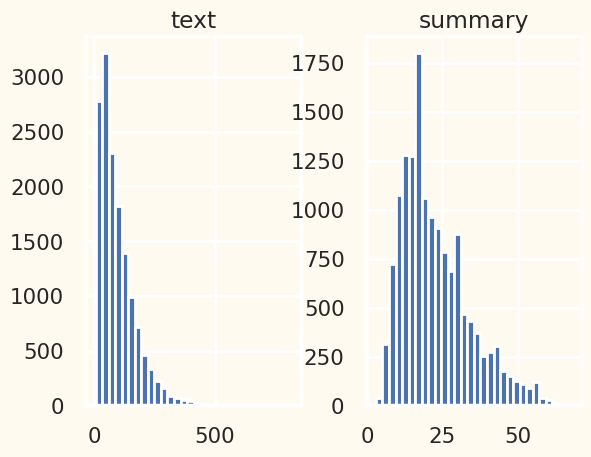

In [23]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_df['dialogue']:
      text_word_count.append(len(i.split()))

for i in train_df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

###Analyzing Summaries Word Cound for Building models

In [24]:
# Count the number of words in each summary
word_counts = train_df['summary'].apply(lambda x: len(x.split()))

In [25]:
# Find the maximum word count
max_word_count = word_counts.max()
print(f'Maximum word count in summaries: {max_word_count}')

Maximum word count in summaries: 68


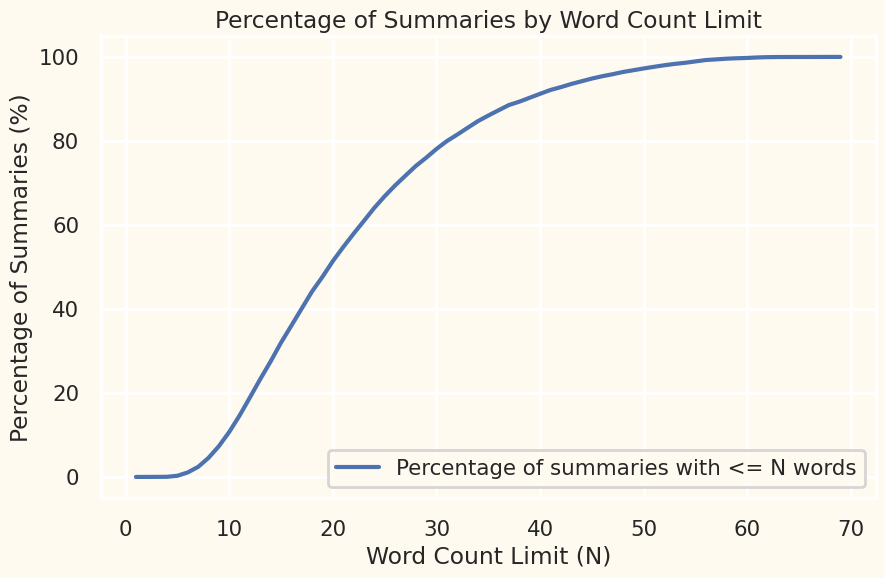

In [26]:
# Create a list to store percentages
percentages = []

# Calculate the percentage of summaries for word limits from 1 to 1000
for limit in range(1, 70):
    cnt = sum(word_counts <= limit)
    percentage = (cnt / len(train_df['summary'])) * 100
    percentages.append(percentage)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 70), percentages, label='Percentage of summaries with <= N words')
plt.title('Percentage of Summaries by Word Count Limit')
plt.xlabel('Word Count Limit (N)')
plt.ylabel('Percentage of Summaries (%)')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
print(train_df['summary'][0].split())

['<start>', 'amanda', 'baked', 'cookies', 'and', 'will', 'bring', 'jerry', 'some', 'tomorrow', '<end>']


In [28]:
limit = 48
cnt = sum(word_counts <= limit)
percentage = (cnt / len(train_df['summary'])) * 100

print(f'Percentage of summaries with {limit} or fewer words: {percentage:.2f}%')


Percentage of summaries with 48 or fewer words: 96.41%


###Analyzing Dislogues Word Cound for Building models

In [29]:
# Count the number of words in each dislogue
word_counts_diag = train_df['dialogue'].apply(lambda x: len(x.split()))

In [30]:
# Find the maximum word count
max_word_count_diag = word_counts_diag.max()
print(f'Maximum word count in dialogues: {max_word_count_diag}')

Maximum word count in dialogues: 819


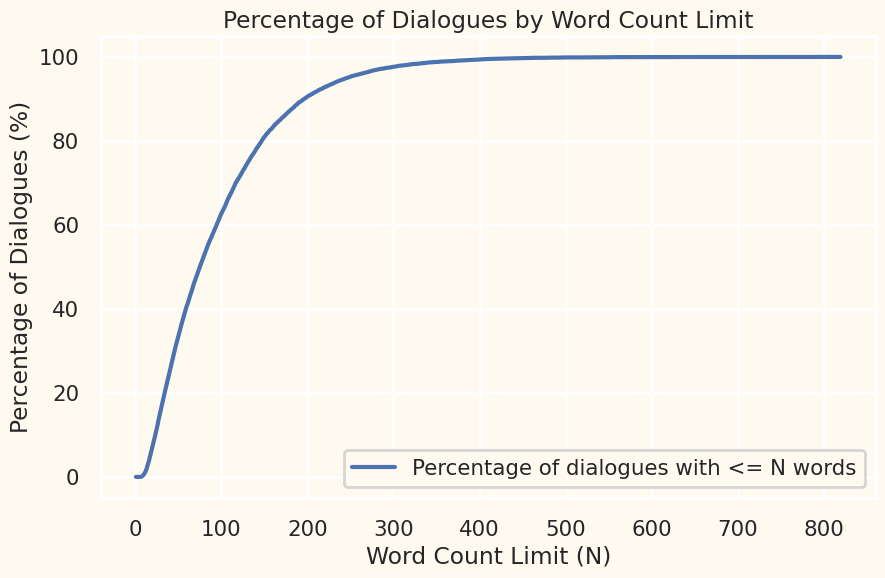

In [31]:
# Create a list to store percentages
percentages = []

# Calculate the percentage of dialogues for word limits from 1 to 1000
for limit in range(1, 820):
    cnt = sum(word_counts_diag <= limit)
    percentage = (cnt / len(train_df['dialogue'])) * 100
    percentages.append(percentage)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 820), percentages, label='Percentage of dialogues with <= N words')
plt.title('Percentage of Dialogues by Word Count Limit')
plt.xlabel('Word Count Limit (N)')
plt.ylabel('Percentage of Dialogues (%)')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
limit = 256
cnt = sum(word_counts_diag <= limit)
percentage = (cnt / len(train_df['dialogue'])) * 100

print(f'Percentage of dialogues with {limit} or fewer words: {percentage:.2f}%')


Percentage of dialogues with 256 or fewer words: 95.64%


###We can build a base model with max_dialogue_len as 256 and max_summary_len as 48

In [33]:
max_dialogue_len=256
max_summary_len=48

##Tokenize on the Data

In [34]:
tok = Tokenizer()
tok.fit_on_texts(train_df['dialogue']+train_df['summary'])

In [35]:
len(tok.word_index)

33246

In [36]:
tok.document_count

14731

##Converting data in numerical forms

In [37]:
# Convert training dialogues and summaries to sequences
train_df['dialogue'] = tok.texts_to_sequences(train_df['dialogue'])
train_df['summary'] = tok.texts_to_sequences(train_df['summary'])

# Convert test dialogues and summaries to sequences (without fitting)
test_df['dialogue'] = tok.texts_to_sequences(test_df['dialogue'])
test_df['summary'] = tok.texts_to_sequences(test_df['summary'])

In [38]:
train_df.head()

,dialogue,summary
0,"[423, 1, 3359, 1528, 15, 2, 71, 52, 584, 70, 4...","[16, 423, 3359, 1528, 6, 12, 211, 584, 52, 98,..."
1,"[318, 144, 18, 2, 5396, 11, 10, 39, 2944, 604,...","[16, 318, 6, 1588, 18, 5396, 11, 11934, 10, 39..."
2,"[225, 116, 26, 7, 60, 356, 217, 1440, 3, 24, 8...","[16, 356, 235, 174, 4, 16210, 13671, 1960, 118..."
3,"[1001, 410, 1, 61, 1, 21, 10, 132, 29, 831, 41...","[16, 1001, 556, 38, 7, 10, 132, 29, 831, 410, ..."
4,"[192, 113, 9658, 491, 167, 109, 192, 1, 15, 8,...","[16, 192, 7, 2350, 110, 38, 9658, 491, 2300, 3..."


In [39]:
# Print corresponding words horizontally
for num in train_df['dialogue'][0]:
    word = tok.index_word.get(num, 'UNK')
    print(word, end=' ')

amanda i baked cookies do you want some jerry sure amanda ill bring you tomorrow 

In [40]:
for num in train_df['summary'][0]:
    word = tok.index_word.get(num)
    print(word,end = " ")

start amanda baked cookies and will bring jerry some tomorrow end 

#Model 1 - Base Reference Model

##Separating the data and padding it

In [41]:
max_dialogue_len=256
max_summary_len=48
lstm_layers = 2

In [42]:
x_train = pad_sequences(train_df['dialogue'],maxlen = max_dialogue_len,padding = 'post')
y_train = pad_sequences(train_df['summary'],maxlen = max_summary_len,padding = 'post')
x_test = pad_sequences(test_df['dialogue'],maxlen =max_dialogue_len,padding = 'post')
y_test = pad_sequences(test_df['summary'],maxlen = max_summary_len,padding = 'post')

In [43]:
# Check the shape of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 256)
Shape of x_test: (819, 256)
Shape of y_train: (14731, 48)
Shape of y_test: (819, 48)


##Modelling

In [44]:
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=128)(encoder_inputs)
for i in range(lstm_layers):
    encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=128)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full Encoder-Decoder model
model_1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 48)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 256, 128)       │      4,255,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 48, 128)        │      4,255,616 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 256, 64),      │         49,408 │ embedding[0][0]        │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 48, 64),       │         49,408 │ embedding_1[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_1[0][1],          │
│                           │ 64)]                   │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 48, 64)         │              0 │ lstm_3[0][0],          │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 48, 128)        │              0 │ lstm_3[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 48, 33247)      │      4,288,863 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,898,911 (49.21 MB)

 Trainable params: 12,898,911 (49.21 MB)

 Non-trainable params: 0 (0.00 B)

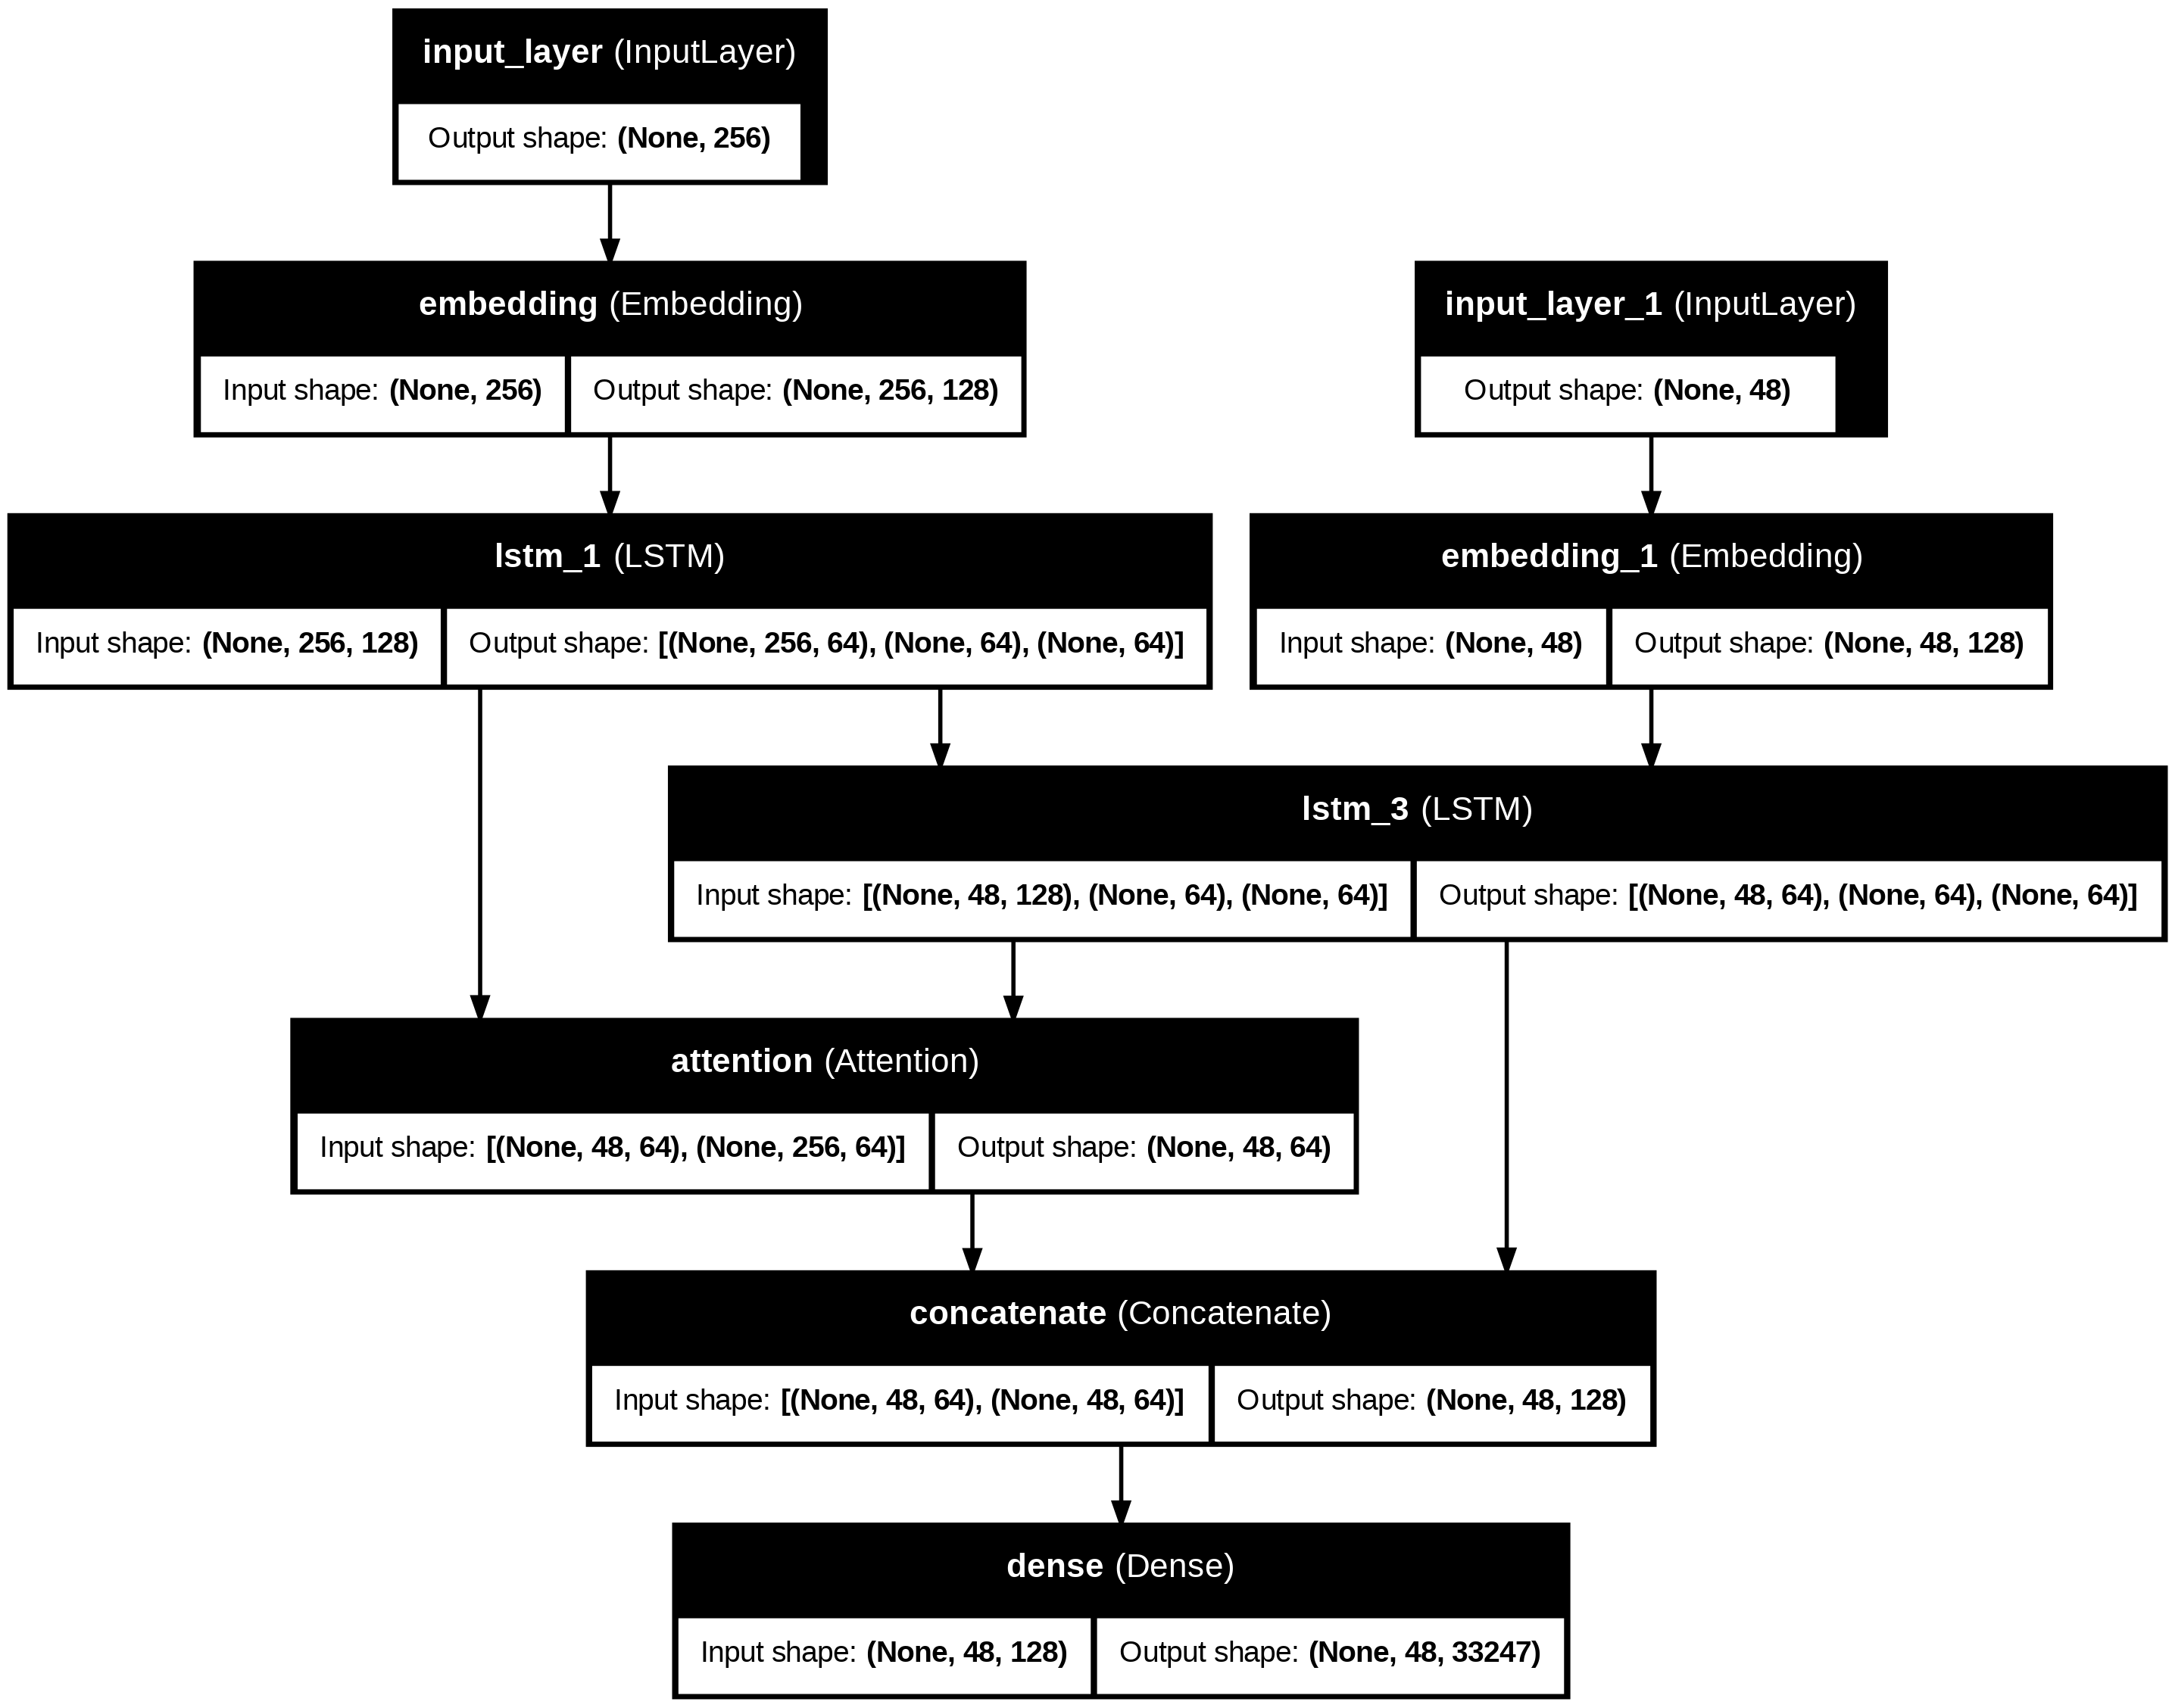

In [45]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath

# Train the model with callbacks
history_1 = model_1.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 53s 102ms/step - accuracy: 0.5525 - loss: 4.5858 - val_accuracy: 0.6639 - val_loss: 2.2323
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - accuracy: 0.6944 - loss: 2.0922 - val_accuracy: 0.8083 - val_loss: 1.4982
Epoch 3/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 77s 94ms/step - accuracy: 0.8108 - loss: 1.4765 - val_accuracy: 0.8588 - val_loss: 1.1279
Epoch 4/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 83s 97ms/step - accuracy: 0.8593 - loss: 1.1216 - val_accuracy: 0.8916 - val_loss: 0.9037
Epoch 5/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.8904 - loss: 0.9043 - val_accuracy: 0.9132 - val_loss: 0.7415


##Model-1 Evaluation

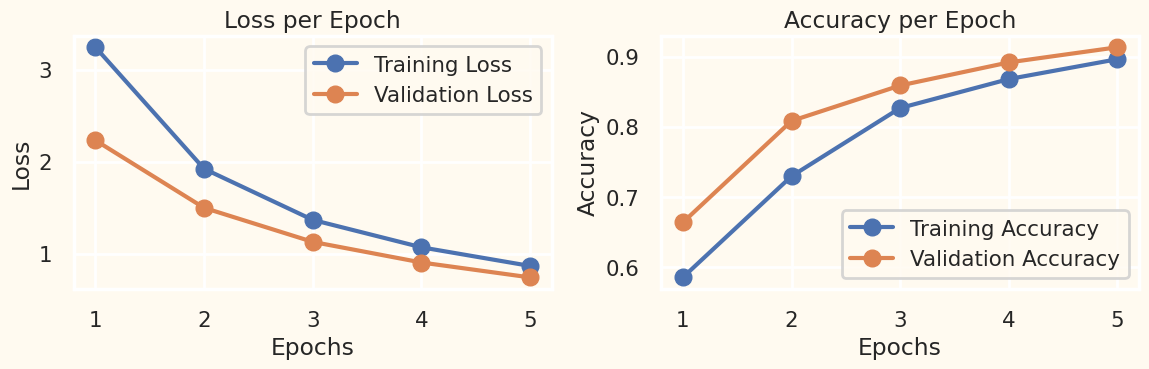

In [47]:
epochs_range = range(1, len(history_1.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_1.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history_1.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_1.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history_1.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.tight_layout()
plt.show()

#Model-2 : Base Model with max_summary_size=68

##Separating the data and padding it

In [48]:
max_dialogue_len=256
max_summary_len=68
lstm_layers = 2

In [49]:
x_train = pad_sequences(train_df['dialogue'],maxlen = max_dialogue_len,padding = 'post')
y_train = pad_sequences(train_df['summary'],maxlen = max_summary_len,padding = 'post')
x_test = pad_sequences(test_df['dialogue'],maxlen =max_dialogue_len,padding = 'post')
y_test = pad_sequences(test_df['summary'],maxlen = max_summary_len,padding = 'post')

In [50]:
# Check the shape of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 256)
Shape of x_test: (819, 256)
Shape of y_train: (14731, 68)
Shape of y_test: (819, 68)


##Modelling

In [51]:
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=128)(encoder_inputs)
for i in range(lstm_layers):
    encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=128)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full Encoder-Decoder model
model_2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 68)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 256, 128)       │      4,255,616 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 68, 128)        │      4,255,616 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 256, 64),      │         49,408 │ embedding_2[0][0]      │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, 68, 64),       │         49,408 │ embedding_3[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_5[0][1],          │
│                           │ 64)]                   │                │ lstm_5[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 68, 64)         │              0 │ lstm_7[0][0],          │
│                           │                        │                │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 68, 128)        │              0 │ lstm_7[0][0],          │
│ (Concatenate)             │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 68, 33247)      │      4,288,863 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,898,911 (49.21 MB)

 Trainable params: 12,898,911 (49.21 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath

# Train the model with callbacks
history_2 = model_2.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 58s 119ms/step - accuracy: 0.6759 - loss: 3.9015 - val_accuracy: 0.7786 - val_loss: 1.6338
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 58s 126ms/step - accuracy: 0.7983 - loss: 1.5413 - val_accuracy: 0.8644 - val_loss: 1.0795
Epoch 3/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.8683 - loss: 1.0461 - val_accuracy: 0.9017 - val_loss: 0.7890
Epoch 4/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 79s 121ms/step - accuracy: 0.9028 - loss: 0.7856 - val_accuracy: 0.9267 - val_loss: 0.6109
Epoch 5/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.9256 - loss: 0.6154 - val_accuracy: 0.9424 - val_loss: 0.4936


##Model-2 Evaluation

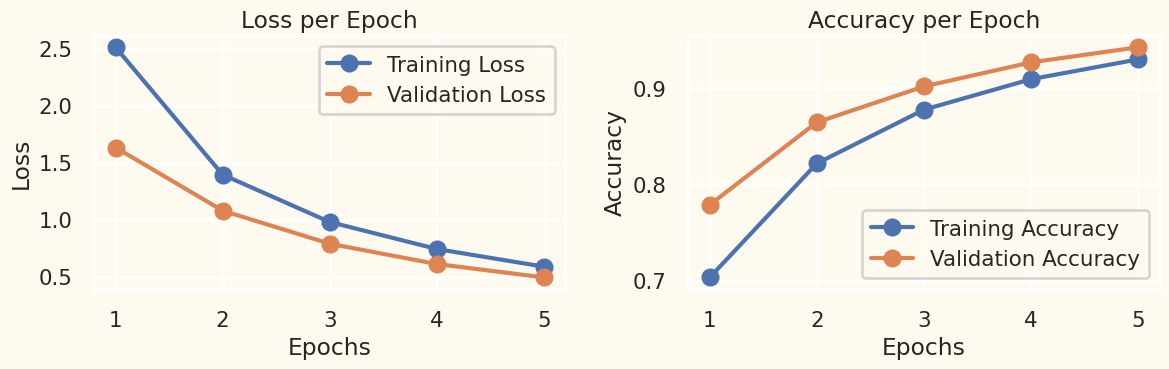

In [53]:
epochs_range = range(1, len(history_2.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_2.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history_2.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history_2.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.tight_layout()
plt.show()

#Model-3 : Base Model with max_dialogue_size=819

##Separating the data and padding it

In [54]:
max_dialogue_len=819
max_summary_len=48
lstm_layers = 2

In [55]:
x_train = pad_sequences(train_df['dialogue'],maxlen = max_dialogue_len,padding = 'post')
y_train = pad_sequences(train_df['summary'],maxlen = max_summary_len,padding = 'post')
x_test = pad_sequences(test_df['dialogue'],maxlen =max_dialogue_len,padding = 'post')
y_test = pad_sequences(test_df['summary'],maxlen = max_summary_len,padding = 'post')

In [56]:
# Check the shape of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 819)
Shape of x_test: (819, 819)
Shape of y_train: (14731, 48)
Shape of y_test: (819, 48)


##Modelling

In [57]:
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=128)(encoder_inputs)
for i in range(lstm_layers):
    encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=128)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full Encoder-Decoder model
model_3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 819)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 48)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 819, 128)       │      4,255,616 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 48, 128)        │      4,255,616 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ [(None, 819, 64),      │         49,408 │ embedding_4[0][0]      │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, 48, 64),       │         49,408 │ embedding_5[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_9[0][1],          │
│                           │ 64)]                   │                │ lstm_9[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 48, 64)         │              0 │ lstm_11[0][0],         │
│                           │                        │                │ lstm_9[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 48, 128)        │              0 │ lstm_11[0][0],         │
│ (Concatenate)             │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 48, 33247)      │      4,288,863 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,898,911 (49.21 MB)

 Trainable params: 12,898,911 (49.21 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath

# Train the model with callbacks
history_3 = model_3.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 58s 120ms/step - accuracy: 0.5550 - loss: 4.5492 - val_accuracy: 0.6976 - val_loss: 2.1929
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.7209 - loss: 2.0626 - val_accuracy: 0.8129 - val_loss: 1.4376
Epoch 3/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.8198 - loss: 1.3916 - val_accuracy: 0.8665 - val_loss: 1.0542
Epoch 4/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.8690 - loss: 1.0388 - val_accuracy: 0.9000 - val_loss: 0.8294
Epoch 5/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.8989 - loss: 0.8230 - val_accuracy: 0.9222 - val_loss: 0.6755


##Model-3 Evaluation

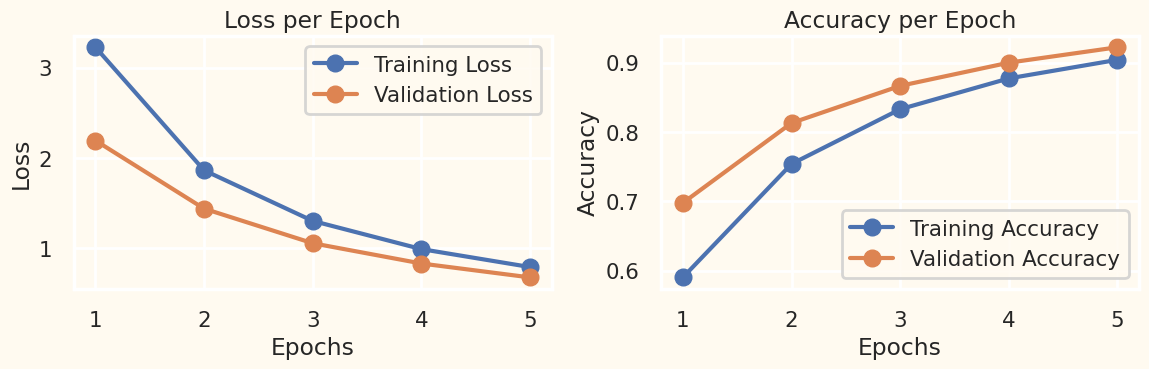

In [59]:
epochs_range = range(1, len(history_3.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_3.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history_3.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_3.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history_3.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.tight_layout()
plt.show()

#Model-4 : Base Model with lstm_layers = 4

##Separating the data and padding it

In [60]:
max_dialogue_len=256
max_summary_len=48
lstm_layers = 4

In [61]:
x_train = pad_sequences(train_df['dialogue'],maxlen = max_dialogue_len,padding = 'post')
y_train = pad_sequences(train_df['summary'],maxlen = max_summary_len,padding = 'post')
x_test = pad_sequences(test_df['dialogue'],maxlen =max_dialogue_len,padding = 'post')
y_test = pad_sequences(test_df['summary'],maxlen = max_summary_len,padding = 'post')

In [62]:
# Check the shape of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 256)
Shape of x_test: (819, 256)
Shape of y_train: (14731, 48)
Shape of y_test: (819, 48)


##Modelling

In [63]:
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=128)(encoder_inputs)
for i in range(lstm_layers):
    encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=128)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full Encoder-Decoder model
model_4 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 48)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 256, 128)       │      4,255,616 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 48, 128)        │      4,255,616 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ [(None, 256, 64),      │         49,408 │ embedding_6[0][0]      │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_17 (LSTM)            │ [(None, 48, 64),       │         49,408 │ embedding_7[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_15[0][1],         │
│                           │ 64)]                   │                │ lstm_15[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_3 (Attention)   │ (None, 48, 64)         │              0 │ lstm_17[0][0],         │
│                           │                        │                │ lstm_15[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 48, 128)        │              0 │ lstm_17[0][0],         │
│ (Concatenate)             │                        │                │ attention_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 48, 33247)      │      4,288,863 │ concatenate_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,898,911 (49.21 MB)

 Trainable params: 12,898,911 (49.21 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath

# Train the model with callbacks
history_4 = model_4.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.5540 - loss: 4.5640 - val_accuracy: 0.6847 - val_loss: 2.2542
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 49s 106ms/step - accuracy: 0.7174 - loss: 2.1335 - val_accuracy: 0.8087 - val_loss: 1.5139
Epoch 3/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.8106 - loss: 1.4842 - val_accuracy: 0.8564 - val_loss: 1.1493
Epoch 4/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - accuracy: 0.8573 - loss: 1.1403 - val_accuracy: 0.8913 - val_loss: 0.9089
Epoch 5/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.8903 - loss: 0.9094 - val_accuracy: 0.9132 - val_loss: 0.7444


##Model-4 Evaluation

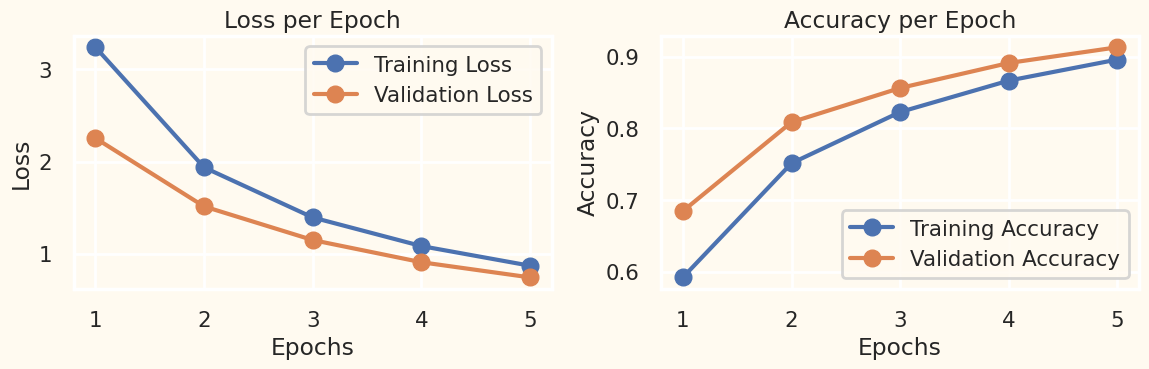

In [65]:
epochs_range = range(1, len(history_4.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_4.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history_4.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_4.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history_4.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.tight_layout()
plt.show()

#Model Evaluation using BLEU and ROUGE scores

In [67]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

In [68]:
# Function to re-pad test data to specific model lengths
def prepare_test_data(test_df, max_dialogue_len, max_summary_len):
    x_test_padded = pad_sequences(test_df['dialogue'], maxlen=max_dialogue_len, padding='post')
    y_test_padded = pad_sequences(test_df['summary'], maxlen=max_summary_len, padding='post')
    return x_test_padded, y_test_padded

# Dictionary to hold models
models = {
    'model_1': model_1,
    'model_2': model_2,
    'model_3': model_3,
    'model_4': model_4
}
# Initialize a results dictionary
results = {
    'Model': [],
    'BLEU': [],
    'ROUGE-1': [],
    'ROUGE-2': [],
    'ROUGE-L': []
}
# Reverse token dictionary for summary
rev_tok_summary = {idx: word for word, idx in tok.word_index.items()}


# Define evaluation function
def evaluate_model(model, x_test, y_test, rev_tok_summary, batch_size=10):
    predicted_summaries = []
    references = []

    # Predict on x_test data in batches
    for start in range(0, len(x_test), batch_size):
        end = min(start + batch_size, len(x_test))
        x_batch = x_test[start:end]
        y_batch = y_test[start:end]  # Use the corresponding y_test for padding purposes

        # Predict on the batch
        predictions = model.predict([x_batch, y_batch], batch_size=batch_size)

        # Convert predicted tokens to sentences (predicted summaries)
        predicted_tokens_np = np.argmax(predictions, axis=-1)

        for sample in predicted_tokens_np:
            # Convert the predicted tokens into the corresponding words for the summary
            predicted_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
            predicted_summaries.append(predicted_sentence)

        # Extract the true (actual) summaries for the BLEU score references
        for i in range(len(y_batch)):
            true_summary_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in y_batch[i] if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
            references.append([true_summary_sentence.split()])  # BLEU expects list of references for each hypothesis

    # Evaluate BLEU score for the predicted summaries
    bleu_score = corpus_bleu(references, [pred.split() for pred in predicted_summaries])

    # Evaluate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in zip(predicted_summaries, references):
        ref_sentence = ' '.join(ref[0])  # Convert list back to string
        scores = scorer.score(ref_sentence, pred)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    avg_rouge_scores = {
        'rouge1': np.mean(rouge_scores['rouge1']),
        'rouge2': np.mean(rouge_scores['rouge2']),
        'rougeL': np.mean(rouge_scores['rougeL'])
    }

    return bleu_score, avg_rouge_scores

# Evaluate each model with its respective max_dialogue_len and max_summary_len
for model_name, model in models.items():
    print(f'Evaluating {model_name}...')

    # Set the correct max lengths for the test set based on the model being evaluated
    if model_name == 'model_1':
        max_dialogue_len, max_summary_len = 256, 48
    elif model_name == 'model_2':
        max_dialogue_len, max_summary_len = 256, 68
    elif model_name == 'model_3':
        max_dialogue_len, max_summary_len = 819, 48
    elif model_name == 'model_4':
        max_dialogue_len, max_summary_len = 256, 48

    # Prepare the test data with the right padding
    x_test_padded, y_test_padded = prepare_test_data(test_df, max_dialogue_len, max_summary_len)

    # Evaluate the model
    bleu, rouge_scores = evaluate_model(model, x_test_padded, y_test_padded, rev_tok_summary)

    # Collect BLEU and ROUGE scores
    results['Model'].append(model_name)
    results['BLEU'].append(bleu)
    results['ROUGE-1'].append(rouge_scores['rouge1'])
    results['ROUGE-2'].append(rouge_scores['rouge2'])
    results['ROUGE-L'].append(rouge_scores['rougeL'])

# Convert the results into a pandas DataFrame for tabulation
results_df = pd.DataFrame(results)


Evaluating model_1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [69]:
# Display the results
print("\nEvaluation Results (BLEU and ROUGE Scores):")
print(results_df)


Evaluation Results (BLEU and ROUGE Scores):
     Model      BLEU   ROUGE-1   ROUGE-2   ROUGE-L
0  model_1  0.571771  0.784003  0.629050  0.783956
1  model_2  0.596933  0.797653  0.650378  0.797597
2  model_3  0.611950  0.804255  0.661410  0.804224
3  model_4  0.573572  0.783868  0.628547  0.783603


###Even if increase more LSTM layers, the scores didn't increase much. But, when the maximum length of the dialogue and maximum length of the Summaries were increased to it's maximum, We can see notable improvement in the scoree, especially, when we increased the maximum dialogue size to 819

#We'll see how well Model 3 performs, as it has the highest BLEU and ROUGE scores.

In [73]:
def display_predictions_and_true_summaries_with_dialogues(model, test_df, rev_tok_summary, num_samples=3, batch_size=10):
    predicted_summaries = []
    true_summaries = []
    dialogues = []

    # Prepare the padded test data
    x_test_padded, y_test_padded = prepare_test_data(test_df, max_dialogue_len, max_summary_len)

    # Predict on x_test data in batches
    for start in range(0, len(x_test_padded), batch_size):
        end = min(start + batch_size, len(x_test_padded))
        x_batch = x_test_padded[start:end]
        y_batch = y_test_padded[start:end]

        # Predict on the batch
        predictions = model.predict([x_batch, y_batch], batch_size=batch_size)

        # Convert predicted tokens to sentences (predicted summaries)
        predicted_tokens_np = np.argmax(predictions, axis=-1)

        for sample in predicted_tokens_np:
            # Convert the predicted tokens into corresponding words for the summary
            predicted_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
            predicted_summaries.append(predicted_sentence)

        # Extract the true (actual) summaries and dialogues
        for i in range(len(y_batch)):
            true_summary_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in y_batch[i] if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
            true_summaries.append(true_summary_sentence)
            dialogues.append(' '.join([rev_tok_summary.get(token, '<unknown>') for token in x_batch[i] if token != 0]))

    # Display the predictions, true summaries, and dialogues for the specified number of samples
    for i in range(num_samples):
        print(f"Sample {i + 1}:")
        print(f"Dialogue: {dialogues[i]}")
        print(f"Predicted Summary: {predicted_summaries[i]}")
        print(f"True Summary: {true_summaries[i]}\n")

# Usage
# Call the function to display predictions for model_3 with dialogues
display_predictions_and_true_summaries_with_dialogues(model_3, test_df, rev_tok_summary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Model 3 is indeed doing pretty good. One thing I can notice is, it is confusing the names. Maybe because the model struggles with the pronouns and mapping them to the correct person. We could try adding an extra Attention layer to make the model give more attention to the words.